In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
base = pd.read_pickle('../data/base_df.pkl')
snli = pd.read_pickle('../data/english_snli_generate_class_shot.pkl')
tweet = pd.read_pickle('../data/english_tweet_eval_generate_class_shot.pkl')
sarcasmania = pd.read_pickle('../data/sarcasmania_generate_class_shot.pkl')
word_context = pd.read_pickle('../data/word_context_generate_class_shot.pkl')

In [3]:
snli['correctness'] = snli['ratio_'].map(lambda x: abs(1 - x))
tweet['correctness'] = tweet['ratio_'].map(lambda x: abs(1 - x))
sarcasmania['correctness'] = sarcasmania['ratio_'].map(lambda x: abs(1 - x))
word_context['correctness'] = word_context['ratio_'].map(lambda x: abs(1 - x))
base['correctness'] = base['ratio'].map(lambda x: abs(1 - x))

In [4]:
base['f1_mean'] = base['mean_f1_of_f1_classes']
llama8 = base[base['model'] == 'meta-llama/Llama-3.1-8B-Instruct']
llama70 = base[base['model'] == 'meta-llama/Llama-3.3-70B-Instruct']
mixtral = base[base['model'] == 'mistralai/Mixtral-8x7B-Instruct-v0.1']

In [5]:
llama8_correctness = llama8[llama8['order'] != 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)
llama70_correctness = llama70[llama70['order'] != 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)
mixtral_correctness = mixtral[mixtral['order'] != 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)

In [6]:
no_few_shot_llama8 = llama8[llama8['order'] == 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)
no_few_shot_llama70 = llama70[llama70['order'] == 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)
no_few_shot_mixtral = mixtral[mixtral['order'] == 'None'].groupby(['task', 'model', 'correctness']).mean()[
    'f1_mean'].reset_index(inplace=False)

# Correctness plots

In [7]:

def create_correctness_plot(ax, df, zero_shot, title):
    correctnesses = [0, 0.5, 1]
    labels = ['correctness: 0', 'correctness: 0.5', 'correctness: 1', '0-shot']
    categories = ['SNLI', 'TweetEval', 'Sarcasmania', 'Word Context']
    series_1 = list(df[df['correctness'] == correctnesses[0]]['f1_mean'])
    series_2 = list(df[df['correctness'] == correctnesses[1]]['f1_mean'])
    series_3 = list(df[df['correctness'] == correctnesses[2]]['f1_mean'])
    series_4 = zero_shot
    x = np.arange(len(categories))
    bar_width = 0.2
    colors = ['#E2A6B5', '#F6C1B5', '#A8D5BA', '#A2A6B5']

    sns.set_theme(style="whitegrid", palette="pastel")
    for i, (series, color, label) in enumerate(
            zip([series_4, series_3, series_2, series_1], colors[::-1], labels[::-1])):
        bars = ax.bar(x + i * bar_width, series, width=bar_width, label=f"{label}",
                      color=color, edgecolor='black', linewidth=0.8, alpha=0.9)

        for bar in bars:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02, f"{bar.get_height():.2f}",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

    ax.set_xlabel('Datasets', fontsize=12, fontweight='bold')
    ax.set_ylabel('F1', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(categories, fontsize=12)
    ax.set_ylim(0, 1.0)
    ax.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

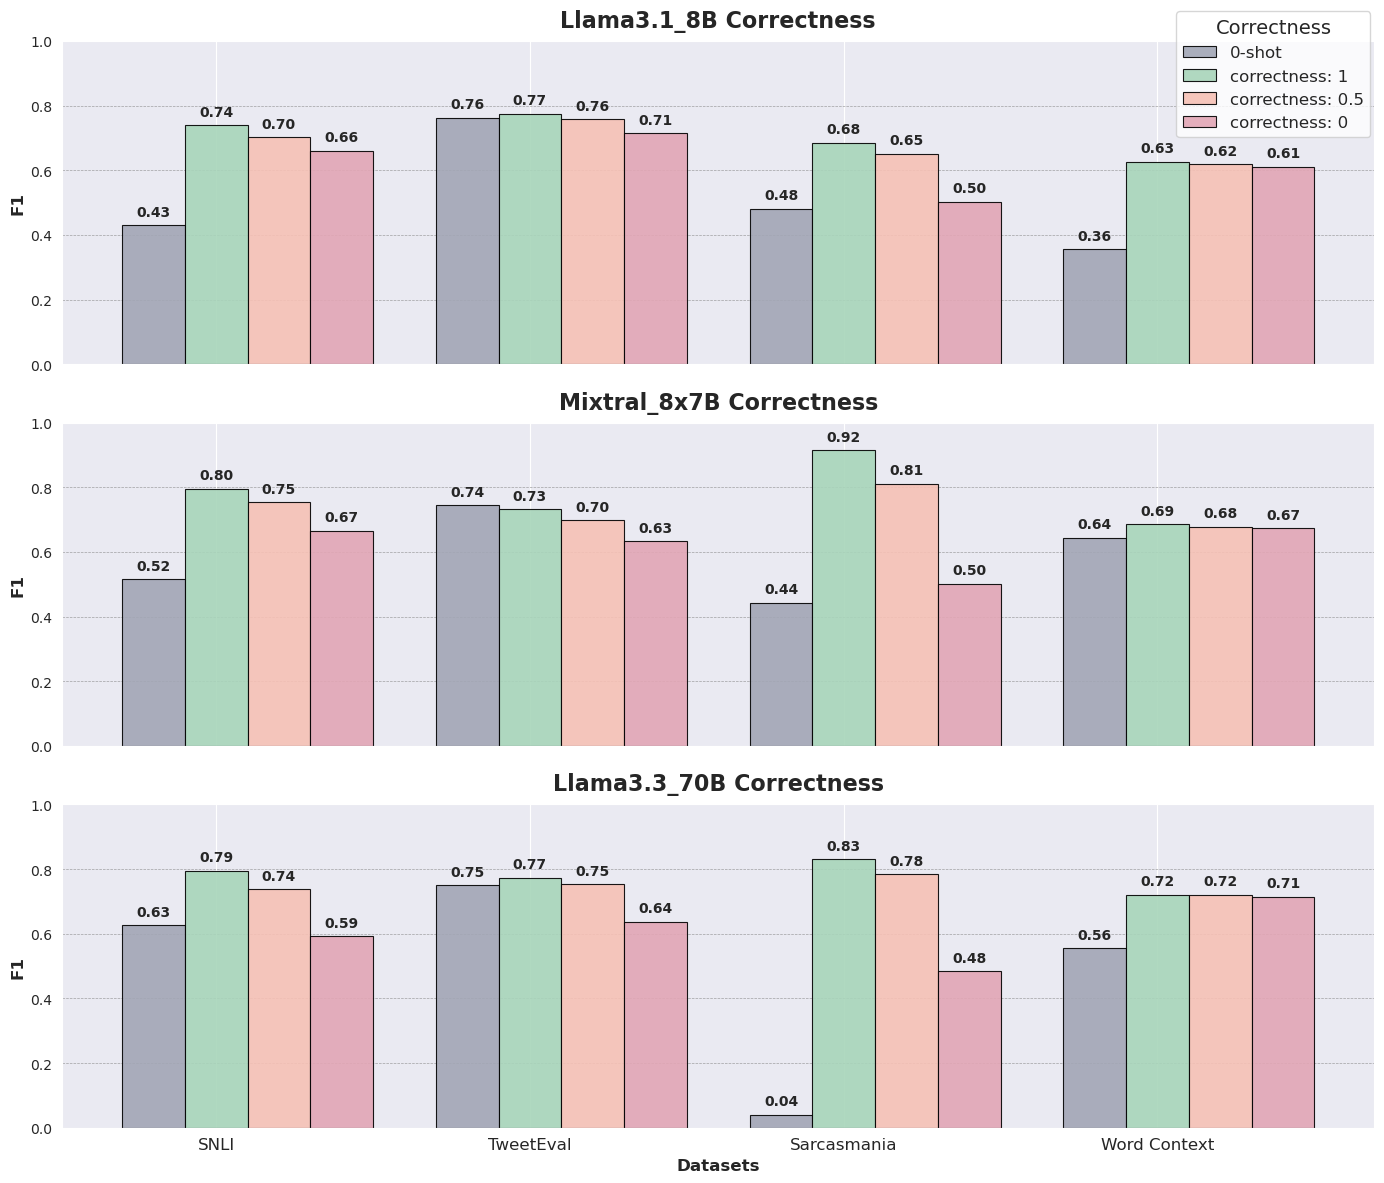

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

create_correctness_plot(axes[0], llama8_correctness[llama8_correctness['task'].isin(
    ['english_snli_generate_class_shot', 'english_tweet_eval_generate_class_shot', 'sarcasmania_generate_class_shot',
     'word_context_generate_class_shot'])],
                        list(llama8[llama8['fewshot'] == 0].groupby(['task', 'model', 'correctness']).mean()[
                                 'f1_mean'].reset_index(inplace=False)['f1_mean']),
                        'Llama3.1_8B Correctness')
create_correctness_plot(axes[1], mixtral_correctness[mixtral_correctness['task'].isin(
    ['english_snli_generate_class_shot', 'english_tweet_eval_generate_class_shot', 'sarcasmania_generate_class_shot',
     'word_context_generate_class_shot'])],
                        list(mixtral[mixtral['fewshot'] == 0].groupby(['task', 'model', 'correctness']).mean()[
                                 'f1_mean'].reset_index(inplace=False)['f1_mean']),
                        'Mixtral_8x7B Correctness')
create_correctness_plot(axes[2], llama70_correctness[llama70_correctness['task'].isin(
    ['english_snli_generate_class_shot', 'english_tweet_eval_generate_class_shot', 'sarcasmania_generate_class_shot',
     'word_context_generate_class_shot'])],
                        list(llama70[llama70['fewshot'] == 0].groupby(['task', 'model', 'correctness']).mean()[
                                 'f1_mean'].reset_index(inplace=False)['f1_mean']),
                        'Llama3.3_70B Correctness')
for ax in axes[:-1]:
    ax.set_xlabel('')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Correctness", fontsize=12, title_fontsize=14,
           loc='upper left', bbox_to_anchor=(0.84, 0.99), ncol=1, frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("combined_correctness_plot.jpg")
plt.show()


In [10]:
low_classes = [2]
all_classes = list(range(4))
high_classes = [0]

precision_columns = [c for c in tweet.columns if 'precision' in c]
recall_columns = [c for c in tweet.columns if 'recall' in c]
f1_columns = [c for c in tweet.columns if 'f1' in c]

precision_low = [c for c in precision_columns if
                 (any(c.startswith(str(cls) + '_') for cls in low_classes) and 'mean' in c)]
recall_low = [c for c in recall_columns if (any(c.startswith(str(cls) + '_') for cls in low_classes) and 'mean' in c)]
f1_low = [c for c in f1_columns if (any(c.startswith(str(cls) + '_') for cls in low_classes) and 'mean' in c)]

precision_high = [c for c in precision_columns if
                  (any(c.startswith(str(cls) + '_') for cls in high_classes) and 'mean' in c)]
recall_high = [c for c in recall_columns if (any(c.startswith(str(cls) + '_') for cls in high_classes) and 'mean' in c)]
f1_high = [c for c in f1_columns if (any(c.startswith(str(cls) + '_') for cls in high_classes) and 'mean' in c)]

precision_all = [c for c in precision_columns if 'mean' in c]
recall_all = [c for c in recall_columns if 'mean' in c]
f1_all = [c for c in f1_columns if 'mean' in c]

In [11]:
tweet['f1_minority_classes'] = tweet[f1_low].mean(axis=1)
tweet['recall_minority_classes'] = tweet[recall_low].mean(axis=1)
tweet['precision_minority_classes'] = tweet[precision_low].mean(axis=1)

tweet['f1_majority_classes'] = tweet[f1_high].mean(axis=1)
tweet['recall_majority_classes'] = tweet[recall_high].mean(axis=1)
tweet['precision_majority_classes'] = tweet[precision_high].mean(axis=1)

In [12]:
tweet_no_ratio = tweet[tweet['ratio_'] == 0].reset_index().drop('index', axis=1)
tweet_no_ratio_few_shot_only = tweet_no_ratio
tweet_no_ratio_few_shot_only_8 = tweet_no_ratio_few_shot_only[
    tweet_no_ratio_few_shot_only['model_'] == 'meta-llama/Llama-3.1-8B-Instruct']
tweet_no_ratio_few_shot_only_70 = tweet_no_ratio_few_shot_only[
    tweet_no_ratio_few_shot_only['model_'] == 'meta-llama/Llama-3.3-70B-Instruct']
tweet_no_ratio_few_shot_only_8x7 = tweet_no_ratio_few_shot_only[
    tweet_no_ratio_few_shot_only['model_'] == 'mistralai/Mixtral-8x7B-Instruct-v0.1']

In [15]:
orders_dict = {'ADBC': 'MIN-MAJ', 'CBDA': 'MAJ-MIN', 'None': 'Few-shot'}
perms = ['AAA', 'ABC', 'RANDOM', 'None']
orders = ['ADBC', 'CBDA', 'None']
minmaj = 'ADBC'
majmin = 'CBDA'
results = []
recall_AAA_MIN = []
recall_AAA_MAJ = []
recall_ABC_MIN = []
recall_ABC_MAJ = []
recall_RANDOM = []
recall_FEW = []
for perm in perms:
    res = "none"
    if perm == 'None':
        res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
            tweet_no_ratio_few_shot_only_8['fewshot_'] != 0].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_FEW.append(res['f1_minority_classes'])
    if perm == 'RANDOM':
        res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        # add to index the permutation
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_RANDOM.append(res['f1_minority_classes'])
    else:
        for order in orders:
            if order == 'None':
                continue
            res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
                tweet_no_ratio_few_shot_only_8['order_'] == order].groupby(['fewshot_']).mean()[
                ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
                 'recall_majority_classes', 'precision_majority_classes']]

            # add to index the permutation
            res.index = res.index.map(lambda x: str(x) + '_' + perm + '_' + orders_dict[order])
            results.append(res)
            if perm == 'AAA':
                if order == minmaj:
                    recall_AAA_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_AAA_MAJ.append(res['f1_minority_classes'])
            if perm == 'ABC':
                if order == minmaj:
                    recall_ABC_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_ABC_MAJ.append(res['f1_minority_classes'])
results.append(tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == 'None'].groupby(
    ['fewshot_']).mean()[
                   ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes',
                    'f1_majority_classes',
                    'recall_majority_classes', 'precision_majority_classes']])

/tmp/ipykernel_10843/3335207616.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
/tmp/ipykernel_10843/3335207616.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
/tmp/ipykernel_10843/3335207616.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
/tmp/ipykernel_10843/3335207616.py:37: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8[tweet_no_ratio_few_shot_only_8['permutation_'] == perm][
/tmp/ipykernel_10843/3335207616.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8[tw

In [16]:
s1 = np.mean(recall_AAA_MIN), np.mean(recall_ABC_MIN), np.mean(recall_AAA_MAJ), np.mean(recall_ABC_MAJ), np.mean(
    recall_RANDOM), np.mean(recall_FEW)

In [19]:
# do the same for 70B
results = []
recall_AAA_MIN = []
recall_AAA_MAJ = []
recall_ABC_MIN = []
recall_ABC_MAJ = []
recall_RANDOM = []
recall_FEW = []

for perm in perms:
    res = "none"
    if perm == 'None':
        res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
            tweet_no_ratio_few_shot_only_70['fewshot_'] != 0].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        # add to index the permutation
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_FEW.append(res['f1_minority_classes'])
    if perm == 'RANDOM':
        res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        # add to index the permutation
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_RANDOM.append(res['f1_minority_classes'])
    else:
        for order in orders:
            if order == 'None':
                continue
            res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
                tweet_no_ratio_few_shot_only_70['order_'] == order].groupby(['fewshot_']).mean()[
                ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
                 'recall_majority_classes', 'precision_majority_classes']]

            # add to index the permutation
            res.index = res.index.map(lambda x: str(x) + '_' + perm + '_' + orders_dict[order])
            results.append(res)
            if perm == 'AAA':
                if order == minmaj:
                    recall_AAA_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_AAA_MAJ.append(res['f1_minority_classes'])
            if perm == 'ABC':
                if order == minmaj:
                    recall_ABC_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_ABC_MAJ.append(res['f1_minority_classes'])
results.append(tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == 'None'].groupby(
    ['fewshot_']).mean()[
                   ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes',
                    'f1_majority_classes',
                    'recall_majority_classes', 'precision_majority_classes']])

/tmp/ipykernel_10843/2020426697.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
/tmp/ipykernel_10843/2020426697.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
/tmp/ipykernel_10843/2020426697.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
/tmp/ipykernel_10843/2020426697.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == perm][
/tmp/ipykernel_10843/2020426697.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_o

In [20]:
s2 = np.mean(recall_AAA_MIN), np.mean(recall_ABC_MIN), np.mean(recall_AAA_MAJ), np.mean(recall_ABC_MAJ), np.mean(
    recall_RANDOM), np.mean(recall_FEW)

In [21]:
# same for 8x7
results = []
recall_AAA_MIN = []
recall_AAA_MAJ = []
recall_ABC_MIN = []
recall_ABC_MAJ = []
recall_RANDOM = []
recall_FEW = []

for perm in perms:
    res = "none"
    if perm == 'None':
        res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
            tweet_no_ratio_few_shot_only_8x7['fewshot_'] != 0].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        # add to index the permutation
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_FEW.append(res['f1_minority_classes'])
    if perm == 'RANDOM':
        res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm].groupby(
            ['fewshot_']).mean()[
            ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
             'recall_majority_classes', 'precision_majority_classes']]
        # add to index the permutation
        res.index = res.index.map(lambda x: str(x) + '_' + perm)
        results.append(res)
        recall_RANDOM.append(res['f1_minority_classes'])
    else:
        for order in orders:
            if order == 'None':
                continue
            res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
                tweet_no_ratio_few_shot_only_8x7['order_'] == order].groupby(['fewshot_']).mean()[
                ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes', 'f1_majority_classes',
                 'recall_majority_classes', 'precision_majority_classes']]

            # add to index the permutation
            res.index = res.index.map(lambda x: str(x) + '_' + perm + '_' + orders_dict[order])
            results.append(res)
            if perm == 'AAA':
                if order == minmaj:
                    recall_AAA_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_AAA_MAJ.append(res['f1_minority_classes'])
            if perm == 'ABC':
                if order == minmaj:
                    recall_ABC_MIN.append(res['f1_minority_classes'])
                if order == majmin:
                    recall_ABC_MAJ.append(res['f1_minority_classes'])
results.append(tweet_no_ratio_few_shot_only_70[tweet_no_ratio_few_shot_only_70['permutation_'] == 'None'].groupby(
    ['fewshot_']).mean()[
                   ['f1_minority_classes', 'recall_minority_classes', 'precision_minority_classes',
                    'f1_majority_classes',
                    'recall_majority_classes', 'precision_majority_classes']])


/tmp/ipykernel_10843/4010723162.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
/tmp/ipykernel_10843/4010723162.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
/tmp/ipykernel_10843/4010723162.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
/tmp/ipykernel_10843/4010723162.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_few_shot_only_8x7[tweet_no_ratio_few_shot_only_8x7['permutation_'] == perm][
/tmp/ipykernel_10843/4010723162.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res = tweet_no_ratio_fe

In [22]:
s3 = np.mean(recall_AAA_MIN), np.mean(recall_ABC_MIN), np.mean(recall_AAA_MAJ), np.mean(recall_ABC_MAJ), np.mean(
    recall_RANDOM), np.mean(recall_FEW)

In [23]:
d = pd.DataFrame([s1, s3, s2], columns=['MIN_AAA', 'MIN_ABC', 'MAJ_AAA', 'MAJ_ABC', 'RANDOM', 'Few-Shot'],
                 index=['Llama3.1_8B', 'Mixtral_8x7B', 'Llama3.3_70B', ])
d

,MIN_AAA,MIN_ABC,MAJ_AAA,MAJ_ABC,RANDOM,Few-Shot
Llama3.1_8B,0.596883,0.604494,0.633067,0.621028,0.618245,0.567512
Mixtral_8x7B,0.496214,0.501875,0.505439,0.481070,0.497025,0.438950
Llama3.3_70B,0.616231,0.628324,0.636601,0.632424,0.628052,0.618789
